### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

### Set-up

In [10]:
# we will read the dataset that we created in the previous exercise

file_loc = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/3d740375d8d00c80e83dacbadc8b5e70cd2bfe48/data/credit_default_model_data.csv'

target = 'default payment next month'

sns.set(style='darkgrid')

### Read data

In [11]:
df = pd.read_csv(file_loc)

df.shape

(30000, 57)

In [12]:
df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_-2_flag,pay_bucket_-1_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,group,default payment next month
0,40000,28,10371,11895,11228,2475,5341,6255,2567,0,...,0,1,11883,47565,0.249827,0,0.198187,0.297375,M,1
1,320000,35,12233,16490,20011,17918,18627,19167,7000,4100,...,0,0,15100,104446,0.144572,0,0.054399,0.062534,M,0
2,260000,35,188,188,188,188,194,188,188,188,...,0,1,1167,1134,1.029101,0,0.000727,0.000746,M,0
3,360000,36,308711,305594,306176,304645,315118,315782,11000,13000,...,0,0,71322,1856026,0.038427,0,0.859271,0.877172,M,0
4,500000,25,-46,9412,1260,0,1121,6566,9458,1260,...,0,1,20839,18313,1.137935,0,0.006104,0.018824,M,0


### Set-up X and y

In [13]:
y = df[target]
X = df.drop(target, axis=1)

del df

### Tri-fold partitioning

In [14]:
X_train = X[X['group'] == 'M'].drop('group', axis=1)
X_test = X[X['group'] == 'T'].drop('group', axis=1)
X_valid = X[X['group'] == 'V'].drop('group', axis=1)

y_train = y[X['group'] == 'M']
y_test = y[X['group'] == 'T']
y_valid = y[X['group'] == 'V']

len(X_train), len(X_test), len(X_valid)

(15000, 7500, 7500)

### Decision Tree

We will fine-tune hyper-parameters for decision (classification) tree now.

#### Max Depth

In [19]:
# create a list of all values we would like to test
max_depths = np.linspace(1, 20, 20)

max_depths

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

We will build a decision tree model using each value of `max_depth`. Once all models are built, we will pick the best value for `max_depth` based on the model performance on the test set.

In [16]:
# create empty arrays -- we will use these to store model performance values
auc_train, auc_test = [], []

for depth in max_depths:
    
    # define the model
    tree = DecisionTreeClassifier(max_depth=depth, random_state=314)
    
    # fit the model
    tree.fit(X_train, y_train)
    
    # get model scores
    tree_scores_train = tree.predict_proba(X_train)[:, 1]
    tree_scores_test = tree.predict_proba(X_test)[:, 1]
    
    # save the AUC values
    auc_train.append(roc_auc_score(y_train, tree_scores_train))
    auc_test.append(roc_auc_score(y_test, tree_scores_test))

Let's plot the model performances.

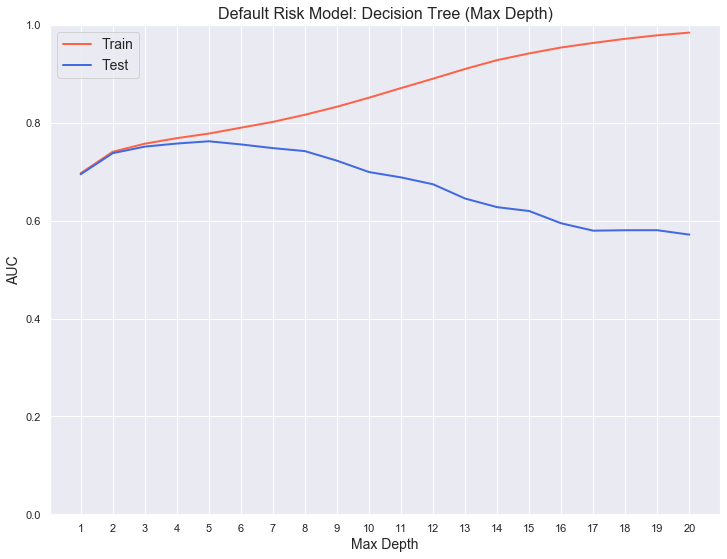

In [17]:
plt.figure().set_size_inches(12, 9)

plt.plot(max_depths, auc_train, color='tomato', lw=2, label='Train')

plt.plot(max_depths, auc_test, color='royalblue', lw=2, label='Test')

plt.xticks(max_depths)
plt.ylim([0.0, 1.0])

plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('AUC', fontsize = 14)
plt.title('Default Risk Model: Decision Tree (Max Depth)', fontsize = 16)
plt.legend(loc='best', fontsize = 14)
plt.show();

Find out where AUC on the test set maximizes.

In [20]:
best_loc = [i for i, auc_test_value in enumerate(auc_test) if auc_test_value == max(auc_test)]
best_loc

[4]

In [21]:
auc_test

[0.6949693034451732,
 0.7380894350159106,
 0.7515132256258353,
 0.7578341790826665,
 0.7624471286940131,
 0.756037457760424,
 0.7484754858577468,
 0.7423484383261142,
 0.7228086834552219,
 0.6995709132286634,
 0.6886262347584504,
 0.6745849109890218,
 0.645418360628282,
 0.6278074540331612,
 0.6198743978089605,
 0.594809222020078,
 0.5797201699927426,
 0.5805923105089109,
 0.5806586048871476,
 0.5716505740313222]

In [22]:
best_auc = auc_test[4]
best_auc

0.7624471286940131

In [23]:
best_max_depth = max_depths[4]
best_max_depth

5.0

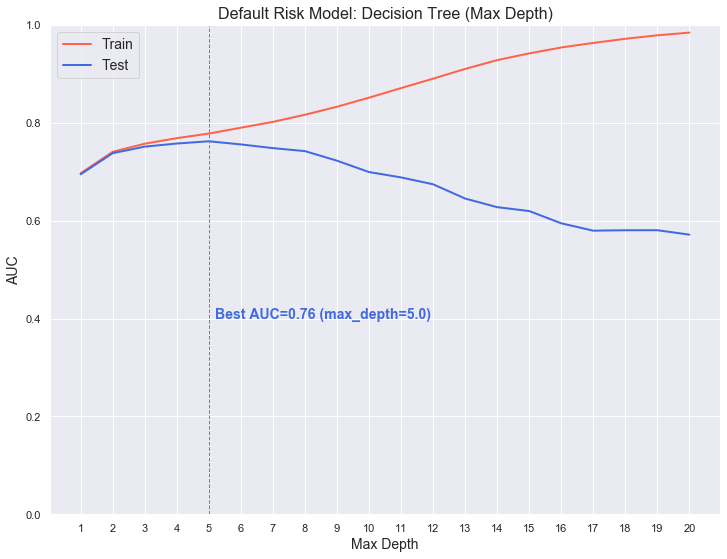

In [24]:
plt.figure().set_size_inches(12, 9)

plt.plot(max_depths, auc_train, color='tomato', lw=2, label='Train')

plt.plot(max_depths, auc_test, color='royalblue', lw=2, label='Test')

plt.plot([5, 5], [0, 1], color='gray', linewidth=1, linestyle='--')
plt.text(5+.2, 0.4, f'Best AUC={best_auc:.2f} (max_depth={best_max_depth})', fontsize=14,
         color='royalblue', weight='semibold')

plt.xticks(max_depths)
plt.ylim([0.0, 1.0])

plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('AUC', fontsize = 14)
plt.title('Default Risk Model: Decision Tree (Max Depth)', fontsize = 16)
plt.legend(loc='best', fontsize = 14)
plt.show();

#### Minimum Samples in the leaf nodes

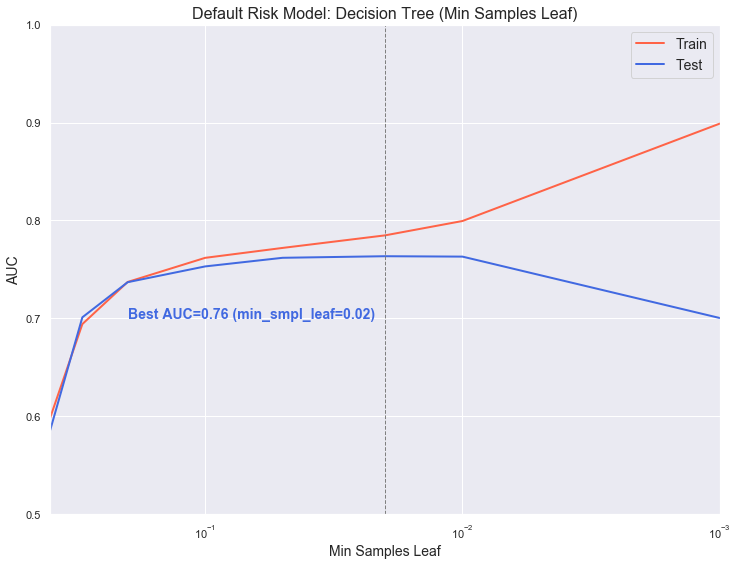

In [25]:
# create a list of all values we would like to test
min_smpl_leaf = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.001]

# create empty arrays -- we will use these to store model performance values
auc_train, auc_test = [], []

for msl in min_smpl_leaf:
    
    # define the model
    tree = DecisionTreeClassifier(min_samples_leaf=msl, random_state=314)
    
    # fit the model
    tree.fit(X_train, y_train)
    
    # get model scores
    tree_scores_train = tree.predict_proba(X_train)[:, 1]
    tree_scores_test = tree.predict_proba(X_test)[:, 1]
    
    # save the AUC values
    auc_train.append(roc_auc_score(y_train, tree_scores_train))
    auc_test.append(roc_auc_score(y_test, tree_scores_test))
  
# identify the best value for min_samples_leaf
best_loc = [i for i, auc_test_value in enumerate(auc_test) if auc_test_value == max(auc_test)][0]
best_auc = auc_test[best_loc]
best_msl = min_smpl_leaf[best_loc]

# plot the model performances
plt.figure().set_size_inches(12, 9)

plt.plot(min_smpl_leaf, auc_train, color='tomato', lw=2, label='Train')

plt.plot(min_smpl_leaf, auc_test, color='royalblue', lw=2, label='Test')

plt.plot([best_msl, best_msl], [0, 1], color='gray', linewidth=1, linestyle='--')
plt.text(0.2, 0.7, f'Best AUC={best_auc:.2f} (min_smpl_leaf={best_msl})', fontsize=14,
         color='royalblue', weight='semibold')

plt.xticks(min_smpl_leaf)
plt.xlim([max(min_smpl_leaf), min(min_smpl_leaf)])
plt.xscale('log')
plt.ylim([0.5, 1.0])

plt.xlabel('Min Samples Leaf', fontsize = 14)
plt.ylabel('AUC', fontsize = 14)
plt.title('Default Risk Model: Decision Tree (Min Samples Leaf)', fontsize = 16)
plt.legend(loc='best', fontsize = 14)
plt.show();

#### Grid-search

Instead of testing (fine-tuning) one hyper-parameter at a time, we can use grid search to assess combination of hyper-parameters.

In [26]:
tree = DecisionTreeClassifier(random_state=314)

# create a list of all parameters we want to test
param_grid = {'max_depth': [4, 5, 6], 'min_samples_leaf': [0.05, 0.03, 0.02]}

# define the gridsearch object
tree_gs = GridSearchCV(tree, param_grid, cv=3, verbose=2, n_jobs=-1)

tree_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=314,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6],
                         'min_samples_leaf': [0.05, 0.03, 0.02]},
             pre_dispatc

Find the best set of hyper-parameters.

In [28]:
tree_gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 0.02}

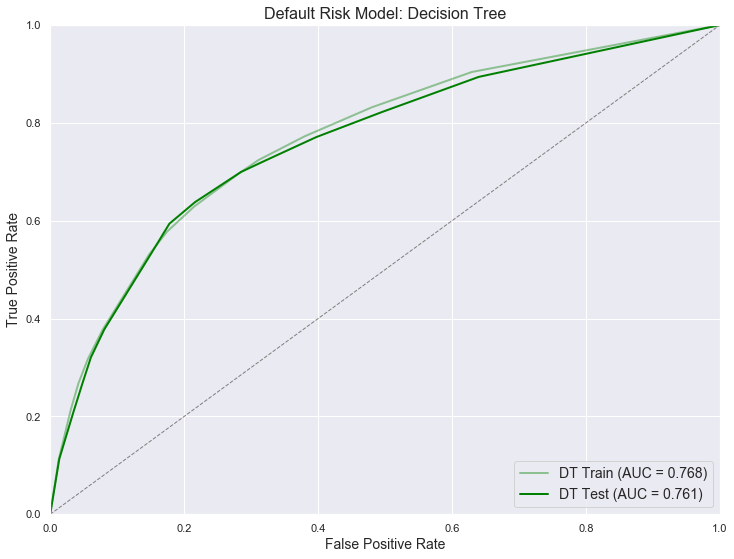

In [29]:
tree_scores_train = tree_gs.predict_proba(X_train)[:, 1]
tree_scores_test = tree_gs.predict_proba(X_test)[:, 1]

tree_fpr_train, tree_tpr_train, _ = roc_curve(y_train, tree_scores_train)
tree_fpr_test, tree_tpr_test, _ = roc_curve(y_test, tree_scores_test)

plt.figure().set_size_inches(12, 9)

plt.plot(tree_fpr_train, tree_tpr_train, color='green', lw=2, alpha = 0.4, linestyle = '-',
         label=f'DT Train (AUC = {roc_auc_score(y_train, tree_scores_train):0.3f})')

plt.plot(tree_fpr_test, tree_tpr_test, color='green', lw=2, linestyle = '-',
         label=f'DT Test (AUC = {roc_auc_score(y_test, tree_scores_test):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Decision Tree', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
plt.show()

### Random Forest

Insted of testing every combination of hyper-parameters, we can perform a random test which picks random combinations from the given set.

We will perform a random-search to optimize the following hyperparameters for a Random Forest model.

Number of trees in random forest: `n_estimators = [200, 300]`

Maximum number of levels in tree: `max_depth = [3, 6]`

Minimum percentage of samples required in the leaf nodes: `min_samples_leaf = [0.02, 0.05]`

Whether to select sub-samples for training each tree: `bootstrap = [True, False]`

In [30]:
forest = RandomForestClassifier(random_state=314)

param_grid = {'n_estimators': [200, 300], 
              'max_depth': [3, 6],
              'min_samples_leaf': [0.02, 0.05],
              'bootstrap': [True, False]}

forest_gs = RandomizedSearchCV(forest, param_grid, cv=3, verbose=2, n_iter=10,
                               n_jobs=-1, random_state=314)

forest_gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [31]:
forest_gs.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 0.02,
 'max_depth': 6,
 'bootstrap': False}

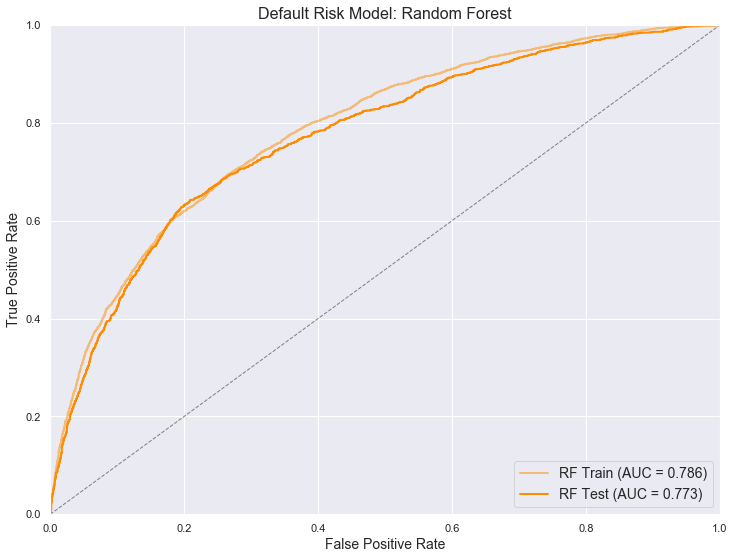

In [32]:
forest_scores_train = forest_gs.predict_proba(X_train)[:, 1]
forest_scores_test = forest_gs.predict_proba(X_test)[:, 1]

forest_fpr_train, forest_tpr_train, _ = roc_curve(y_train, forest_scores_train)
forest_fpr_test, forest_tpr_test, _ = roc_curve(y_test, forest_scores_test)

plt.figure().set_size_inches(12, 9)

plt.plot(forest_fpr_train, forest_tpr_train, color='darkorange', lw=2, alpha = 0.5, linestyle = '-',
         label=f'RF Train (AUC = {roc_auc_score(y_train, forest_scores_train):0.3f})')

plt.plot(forest_fpr_test, forest_tpr_test, color='darkorange', lw=2, linestyle = '-',
         label=f'RF Test (AUC = {roc_auc_score(y_test, forest_scores_test):0.3f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Random Forest', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
plt.show();

Note: Once you find the best set of hyper-parameters, you can further refine them by performing another random search using a new set of hyper-parameters -- the new values (to be tested) can be chosen based on the results from the first random search.

**EXERCISE:**
    
Perform a random-search to optimize the following hyperparameters for a *Gradient Boosting* model.

Number of trees: `n_estimators = [100, 300, 500]`

Learning rate: `learning_rate = [0.05, 0.1, .5]`

Maximum number of levels in tree: `max_depth = [3, 6]`

Minimum percentage of samples required in the leaf nodes: `min_samples_leaf = [0.01, 0.02, 0.05]`


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=314)

param_grid = {'n_estimators': [100, 300, 500], 
              'learning_rate': [0.05, 0.1, 0.5],
              'max_depth': [3, 6],
              'min_samples_leaf': [0.01, 0.02, 0.05]}

gbm_rs = RandomizedSearchCV(gbm, param_grid, cv=3, n_iter=10, n_jobs=-1, random_state=314)

gbm_rs.fit(X_train, y_train)

print ('Best GBM Parameters:', gbm_rs.best_params_)

gbm_scores_train = gbm_rs.predict_proba(X_train)[:, 1]
gbm_scores_test = gbm_rs.predict_proba(X_test)[:, 1]

gbm_fpr_train, gbm_tpr_train, _ = roc_curve(y_train, gbm_scores_train)
gbm_fpr_test, gbm_tpr_test, _ = roc_curve(y_test, gbm_scores_test)

Best GBM Parameters: {'n_estimators': 100, 'min_samples_leaf': 0.02, 'max_depth': 3, 'learning_rate': 0.1}


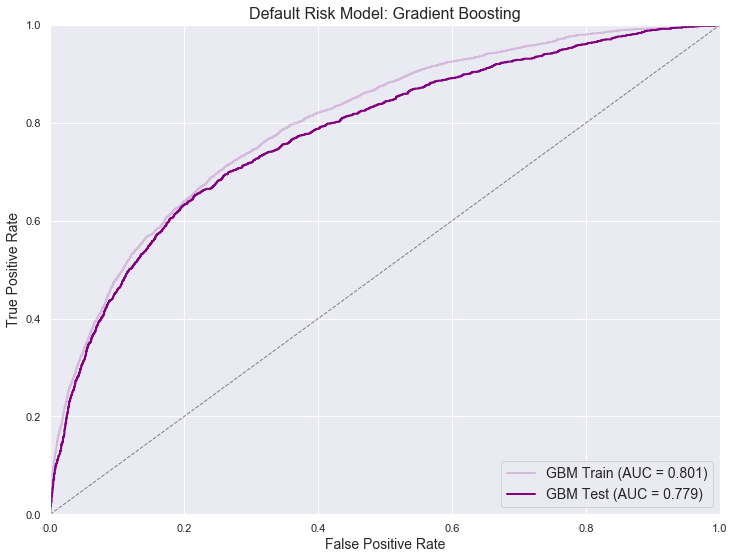

In [34]:
# ROC Curve
plt.figure().set_size_inches(12, 9)

plt.plot(gbm_fpr_train, gbm_tpr_train, color='purple', lw=2, alpha = 0.2, linestyle = '-',
         label=f'GBM Train (AUC = {roc_auc_score(y_train, gbm_scores_train):0.3f})')

plt.plot(gbm_fpr_test, gbm_tpr_test, color='purple', lw=2, linestyle = '-',
         label=f'GBM Test (AUC = {roc_auc_score(y_test, gbm_scores_test):0.3f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Gradient Boosting', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
plt.show();

Let's see what would have happened if we ran a full grid search.

In [38]:
gbm_gs = GridSearchCV(gbm, param_grid, cv=3, n_jobs=-1)

gbm_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [39]:
gbm_gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_samples_leaf': 0.02,
 'n_estimators': 100}

The best hyper-parameters are different than what the random search had identified.